In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from matplotlib.pyplot import imshow

import torch 
from torch import nn, Tensor
from torchvision import transforms
from datasets import load_dataset

In [11]:
# load mnist
mnist = load_dataset("ylecun/mnist")
imshow(mnist['train'][0]['image'])

In [36]:
# preprocessing
batch_size = 64

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# wrapper to apply transform
class MNISTDataset():
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        image = self.transform(image)
        return image, label

train_dataset = MNISTDataset(mnist['train'], transform=transform)
test_dataset = MNISTDataset(mnist['test'], transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


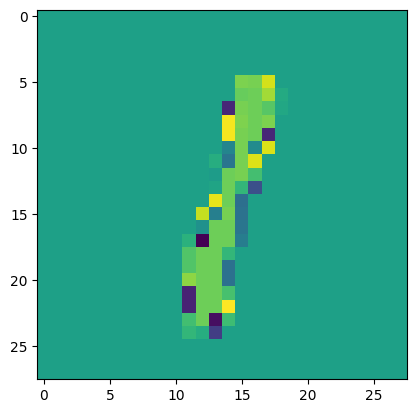

In [37]:
# example : iterate over one batch
for images, labels in train_loader:
    print(images.shape)  # [64, 1, 28, 28]
    print(labels.shape)  # [64]
    break
    
imshow(transforms.functional.to_pil_image(images[5][0]))

In [63]:
# flow model -> MLP
vec_dim = 784
hidden_dim = 2048

class Flow(nn.Module):
    def __init__(self, dim: int = vec_dim, h: int = hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        # design choice
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        # midpoint ODE solver
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [64]:
device = 'cuda:0'

In [65]:
epochs = 20

flow = Flow()
flow.to(device)

optimizer = torch.optim.Adam(flow.parameters(), 3e-5)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    epoch_loss = 0 
    for images, _ in train_loader:
    
        # flatten images
        x_1 = images.reshape(batch_size, -1).to(device)
        # noise
        x_0 = torch.randn_like(x_1)
        # time 
        t = torch.rand(len(x_1), 1).to(device)
    
        # linear interpolation
        x_t = (1 - t) * x_0 + t * x_1
        # velocity
        dx_t = x_1 - x_0
    
        optimizer.zero_grad()
        loss = loss_fn(flow(t=t, x_t=x_t), dx_t)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print('Epoch : {} Loss : {}'.format(epoch+1, epoch_loss / len(train_loader)))

Epoch : 1 Loss : 1.487818957265693
Epoch : 2 Loss : 1.3824286437976068
Epoch : 3 Loss : 1.3497435629304215
Epoch : 4 Loss : 1.3274322297809726
Epoch : 5 Loss : 1.3070134467732564
Epoch : 6 Loss : 1.280908215389435
Epoch : 7 Loss : 1.253551381374754
Epoch : 8 Loss : 1.2275153728025063
Epoch : 9 Loss : 1.2022226256265711
Epoch : 10 Loss : 1.1806316608553127
Epoch : 11 Loss : 1.1597080814673018
Epoch : 12 Loss : 1.1394312127295527
Epoch : 13 Loss : 1.1221980752151066
Epoch : 14 Loss : 1.1051369465275278
Epoch : 15 Loss : 1.087811192682484
Epoch : 16 Loss : 1.0730489362647464
Epoch : 17 Loss : 1.0606303461206126
Epoch : 18 Loss : 1.047604163720997
Epoch : 19 Loss : 1.0335361997625745
Epoch : 20 Loss : 1.0211594987068258


# Sampling

In [ ]:
n_steps = 8

x = torch.randn(1, vec_dim).to('cuda')
time_steps = torch.linspace(0, 1.0, n_steps + 1).to('cuda')

# FIX
for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    image = x.reshape(-1, 28)
    imshow(transforms.functional.to_pil_image(image))

plt.tight_layout()
plt.show()